# Import libraries

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import json
import cv2
import matplotlib
import matplotlib.pyplot as plt
import scipy
import warnings
import shutil
import random

from PIL import Image
from tqdm import tqdm

# Install MMDetection

In [2]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

# Check Pytorch installation
import torch
print(torch.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

1.6.0


In [3]:
!python -m pip install --upgrade pip

     |████████████████████████████████| 2.1 MB 624 kB/s 
  Attempting uninstall: pip
    Found existing installation: pip 20.2.3
    Uninstalling pip-20.2.3:
      Successfully uninstalled pip-20.2.3


In [4]:
!pip install openmim --use-feature=2020-resolver
!mim install mmdet

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -r requirements/build.txt 
!pip install -v -e . 

  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 KB 710.1 kB/s eta 0:00:00
  Created wheel for openmim: filename=openmim-0.1.5-py2.py3-none-any.whl size=42502 sha256=285b707296ae5a9cff727d4cc76ebf18ae223475b379ddc466f3967b4a08509b
  Stored in directory: /root/.cache/pip/wheels/16/8b/e1/bdebbbc687aa50224a5ce46fe97a040a0c59f92b34bfc750b6
Successfully built openmim
  Attempting uninstall: Click
    Found existing installation: click 7.1.1
    Uninstalling click-7.1.1:
      Successfully uninstalled click-7.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-xgboost 0.1.11 requires xgboost<=0.90, but you have xgboost 1.2.0 which is incompatible.
installing mmdet from https://github.com/open-mmlab/mmdetection.git.
Cloning into '/tmp/tmpiac5yfug/mmdetection'...
remote: Enumerating objects: 24362, done.
remote: C

In [5]:
from mmcv import collect_env
collect_env()

{'sys.platform': 'linux',
 'Python': '3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) [GCC 7.3.0]',
 'CUDA available': True,
 'GPU 0': 'Tesla P100-PCIE-16GB',
 'CUDA_HOME': '/usr/local/cuda',
 'NVCC': 'Cuda compilation tools, release 10.1, V10.1.24',
 'GCC': 'gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0',
 'PyTorch': '1.6.0',
 'PyTorch compiling details': 'PyTorch built with:\n  - GCC 7.3\n  - C++ Version: 201402\n  - Intel(R) Math Kernel Library Version 2019.0.5 Product Build 20190808 for Intel(R) 64 architecture applications\n  - Intel(R) MKL-DNN v1.5.0 (Git Hash e2ac1fac44c5078ca927cb9b90e1b3066a0b2ed0)\n  - OpenMP 201511 (a.k.a. OpenMP 4.5)\n  - NNPACK is enabled\n  - CPU capability usage: AVX2\n  - CUDA Runtime 10.1\n  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;

In [6]:
# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

2.24.1
10.1
GCC 7.3


# Register PanNuke as new dataset

In [7]:
#parse the order of categories in the json file
import json

with open('../../input/pannuke-coco/train.json', 'r') as json_file:
    json_load = json.load(json_file)

CLASSES = []
for i in range(5):
    #print(json_load['categories'][i]['name'])
    CLASSES.append(json_load['categories'][i]['name'])

print(CLASSES)

['neoplastic', 'inflammatory', 'softtissue', 'dead', 'epithelial']


In [8]:
# where the checkpoints will be saved
if not os.path.isdir('./work_dirs'):
    os.makedirs('./work_dirs')

# Make the config file

In [9]:
from mmcv import Config
cfg = Config.fromfile('./configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py')

In [10]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'COCODataset'

# Modify dataset type and path
cfg.data_root = '../../input/pannuke-coco'

cfg.data.train.classes = (CLASSES[0], CLASSES[1], CLASSES[2], CLASSES[3], CLASSES[4])
cfg.data.train.ann_file = cfg.data_root + '/train.json'
cfg.data.train.img_prefix = cfg.data_root + '/train/'

cfg.data.val.classes = (CLASSES[0], CLASSES[1], CLASSES[2], CLASSES[3], CLASSES[4])
cfg.data.val.ann_file = cfg.data_root + '/val.json'
cfg.data.val.img_prefix = cfg.data_root + '/val/'

cfg.data.test.classes = (CLASSES[0], CLASSES[1], CLASSES[2], CLASSES[3], CLASSES[4])
cfg.data.test.ann_file = cfg.data_root + '/val.json'
cfg.data.test.img_prefix = cfg.data_root + '/val/'

# modify num classes of the model in box head and mask head
cfg.model.roi_head.bbox_head.num_classes = 5
cfg.model.roi_head.mask_head.num_classes = 5

# If we need to finetune a model based on a pre-trained detector
cfg.load_from = None

#set the working directory
cfg.work_dir = './work_dirs'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 50

# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 1
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

cfg.lr_config = dict(
    policy='step',
    warmup='linear',
    warmup_iters=500,
    warmup_ratio=0.001,
    step=[8, 11, 20, 23, 32, 35])

cfg.runner = dict(type='EpochBasedRunner', max_epochs=36)

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = 'cuda'

# set different configs for every data
cfg_train = cfg
cfg_test = cfg
cfg_inference = cfg

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_wei

# Start training

In [11]:
import mmcv
import os.path as osp
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# Build dataset
datasets = [build_dataset(cfg_train.data.train)]

# Build the detector
model = build_detector(cfg_train.model)

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg_train.work_dir))

#train
train_detector(model, datasets, cfg_train, distributed=False, validate=True)

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


2022-05-08 16:18:06,198 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.


loading annotations into memory...


2022-05-08 16:18:06,599 - mmdet - INFO - Start running, host: root@f301c00abf3a, work_dir: /kaggle/working/mmdetection/work_dirs
2022-05-08 16:18:06,601 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
 -------------------- 
after_train_iter:
(ABOVE_NORMAL) OptimizerHook     

Done (t=0.38s)
creating index...
index created!


2022-05-08 16:18:32,017 - mmdet - INFO - Epoch [1][50/1016]	lr: 2.473e-04, eta: 5:08:40, time: 0.507, data_time: 0.158, memory: 2711, loss_rpn_cls: 0.6628, loss_rpn_bbox: 0.1940, loss_cls: 1.0687, acc: 76.3145, loss_bbox: 0.0424, loss_mask: 0.6979, loss: 2.6657
2022-05-08 16:18:55,956 - mmdet - INFO - Epoch [1][100/1016]	lr: 4.970e-04, eta: 4:59:39, time: 0.479, data_time: 0.118, memory: 3074, loss_rpn_cls: 0.4835, loss_rpn_bbox: 0.1795, loss_cls: 0.5194, acc: 88.8184, loss_bbox: 0.2900, loss_mask: 0.6938, loss: 2.1662
2022-05-08 16:19:20,099 - mmdet - INFO - Epoch [1][150/1016]	lr: 7.468e-04, eta: 4:57:12, time: 0.483, data_time: 0.107, memory: 3074, loss_rpn_cls: 0.4148, loss_rpn_bbox: 0.1793, loss_cls: 0.6312, acc: 83.4609, loss_bbox: 0.5247, loss_mask: 0.6824, loss: 2.4324
2022-05-08 16:19:44,748 - mmdet - INFO - Epoch [1][200/1016]	lr: 9.965e-04, eta: 4:57:19, time: 0.493, data_time: 0.106, memory: 3074, loss_rpn_cls: 0.3930, loss_rpn_bbox: 0.1691, loss_cls: 0.5883, acc: 84.4883, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.0 task/s, elapsed: 57s, ETA:     0s

2022-05-08 16:27:32,374 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=38.75s).
Accumulating evaluation results...


2022-05-08 16:28:14,301 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.124
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.058
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.153
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.153
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.153
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.153
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.55s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.81s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=39.85s).
Accumulating evaluation results...


2022-05-08 16:28:57,654 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.119
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.042
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.094
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.146
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.146
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.146
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.178
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.88s).


2022-05-08 16:29:26,169 - mmdet - INFO - Epoch [2][50/1016]	lr: 2.500e-03, eta: 4:52:00, time: 0.566, data_time: 0.164, memory: 3106, loss_rpn_cls: 0.1885, loss_rpn_bbox: 0.1532, loss_cls: 0.7091, acc: 77.6621, loss_bbox: 0.6609, loss_mask: 0.4102, loss: 2.1219
2022-05-08 16:29:51,513 - mmdet - INFO - Epoch [2][100/1016]	lr: 2.500e-03, eta: 4:51:57, time: 0.507, data_time: 0.115, memory: 3106, loss_rpn_cls: 0.1925, loss_rpn_bbox: 0.1548, loss_cls: 0.7307, acc: 76.9609, loss_bbox: 0.6714, loss_mask: 0.3958, loss: 2.1451
2022-05-08 16:30:17,154 - mmdet - INFO - Epoch [2][150/1016]	lr: 2.500e-03, eta: 4:52:01, time: 0.513, data_time: 0.117, memory: 3106, loss_rpn_cls: 0.2098, loss_rpn_bbox: 0.1539, loss_cls: 0.7038, acc: 78.3477, loss_bbox: 0.6431, loss_mask: 0.4042, loss: 2.1149
2022-05-08 16:30:41,428 - mmdet - INFO - Epoch [2][200/1016]	lr: 2.500e-03, eta: 4:51:22, time: 0.485, data_time: 0.101, memory: 3106, loss_rpn_cls: 0.1577, loss_rpn_bbox: 0.1332, loss_cls: 0.6844, acc: 77.9531, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 8.8 task/s, elapsed: 57s, ETA:     0s

2022-05-08 16:38:38,202 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.10s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=37.99s).
Accumulating evaluation results...


2022-05-08 16:39:18,868 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.155
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.166
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.166
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.166
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.164
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.177
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.97s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.83s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=38.03s).
Accumulating evaluation results...


2022-05-08 16:40:00,732 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.064
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.154
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.063
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.078
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.159
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.159
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.159
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.188
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.92s).


2022-05-08 16:40:30,934 - mmdet - INFO - Epoch [3][50/1016]	lr: 2.500e-03, eta: 4:46:47, time: 0.600, data_time: 0.187, memory: 3114, loss_rpn_cls: 0.1592, loss_rpn_bbox: 0.1402, loss_cls: 0.6743, acc: 78.2070, loss_bbox: 0.6169, loss_mask: 0.3687, loss: 1.9593
2022-05-08 16:40:56,492 - mmdet - INFO - Epoch [3][100/1016]	lr: 2.500e-03, eta: 4:46:32, time: 0.511, data_time: 0.105, memory: 3114, loss_rpn_cls: 0.1471, loss_rpn_bbox: 0.1446, loss_cls: 0.6755, acc: 77.6113, loss_bbox: 0.6412, loss_mask: 0.3719, loss: 1.9804
2022-05-08 16:41:22,540 - mmdet - INFO - Epoch [3][150/1016]	lr: 2.500e-03, eta: 4:46:24, time: 0.521, data_time: 0.117, memory: 3114, loss_rpn_cls: 0.1404, loss_rpn_bbox: 0.1313, loss_cls: 0.6835, acc: 77.9023, loss_bbox: 0.6207, loss_mask: 0.3839, loss: 1.9598
2022-05-08 16:41:47,844 - mmdet - INFO - Epoch [3][200/1016]	lr: 2.500e-03, eta: 4:46:04, time: 0.506, data_time: 0.102, memory: 3114, loss_rpn_cls: 0.1394, loss_rpn_bbox: 0.1266, loss_cls: 0.6719, acc: 77.8047, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 8.9 task/s, elapsed: 57s, ETA:     0s

2022-05-08 16:49:42,574 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.09s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=33.41s).
Accumulating evaluation results...


2022-05-08 16:50:18,410 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.089
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.197
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.066
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.101
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.067
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.235
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.235
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.235
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.228
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.328
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.07s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=1.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=34.03s).
Accumulating evaluation results...


2022-05-08 16:50:56,343 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.082
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.191
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.055
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.079
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.140
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.221
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.221
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.221
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.213
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.326
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.00s).


2022-05-08 16:51:23,887 - mmdet - INFO - Epoch [4][50/1016]	lr: 2.500e-03, eta: 4:38:57, time: 0.547, data_time: 0.159, memory: 3114, loss_rpn_cls: 0.1141, loss_rpn_bbox: 0.1223, loss_cls: 0.6386, acc: 78.3301, loss_bbox: 0.5976, loss_mask: 0.3488, loss: 1.8213
2022-05-08 16:51:47,378 - mmdet - INFO - Epoch [4][100/1016]	lr: 2.500e-03, eta: 4:38:16, time: 0.470, data_time: 0.089, memory: 3114, loss_rpn_cls: 0.1188, loss_rpn_bbox: 0.1146, loss_cls: 0.6284, acc: 79.0234, loss_bbox: 0.5807, loss_mask: 0.3531, loss: 1.7957
2022-05-08 16:52:13,322 - mmdet - INFO - Epoch [4][150/1016]	lr: 2.500e-03, eta: 4:38:01, time: 0.519, data_time: 0.120, memory: 3114, loss_rpn_cls: 0.1274, loss_rpn_bbox: 0.1203, loss_cls: 0.6382, acc: 78.7793, loss_bbox: 0.6049, loss_mask: 0.3580, loss: 1.8489
2022-05-08 16:52:38,759 - mmdet - INFO - Epoch [4][200/1016]	lr: 2.500e-03, eta: 4:37:41, time: 0.509, data_time: 0.117, memory: 3114, loss_rpn_cls: 0.1111, loss_rpn_bbox: 0.1247, loss_cls: 0.6501, acc: 78.1074, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.2 task/s, elapsed: 55s, ETA:     0s

2022-05-08 17:00:28,564 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.25s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=36.14s).
Accumulating evaluation results...


2022-05-08 17:01:07,972 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.220
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.087
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.117
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.117
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.247
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.247
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.247
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.405
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.07s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.72s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=36.12s).
Accumulating evaluation results...


2022-05-08 17:01:47,860 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.100
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.216
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.078
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.098
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.204
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.233
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.233
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.233
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.224
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.405
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.05s).


2022-05-08 17:02:15,979 - mmdet - INFO - Epoch [5][50/1016]	lr: 2.500e-03, eta: 4:30:11, time: 0.559, data_time: 0.160, memory: 3114, loss_rpn_cls: 0.0964, loss_rpn_bbox: 0.1182, loss_cls: 0.6295, acc: 78.2500, loss_bbox: 0.6024, loss_mask: 0.3434, loss: 1.7898
2022-05-08 17:02:43,086 - mmdet - INFO - Epoch [5][100/1016]	lr: 2.500e-03, eta: 4:30:03, time: 0.542, data_time: 0.138, memory: 3114, loss_rpn_cls: 0.1146, loss_rpn_bbox: 0.1295, loss_cls: 0.6501, acc: 78.2402, loss_bbox: 0.5901, loss_mask: 0.3457, loss: 1.8301
2022-05-08 17:03:08,364 - mmdet - INFO - Epoch [5][150/1016]	lr: 2.500e-03, eta: 4:29:40, time: 0.506, data_time: 0.111, memory: 3114, loss_rpn_cls: 0.1161, loss_rpn_bbox: 0.1259, loss_cls: 0.6166, acc: 79.4414, loss_bbox: 0.5824, loss_mask: 0.3553, loss: 1.7964
2022-05-08 17:03:33,741 - mmdet - INFO - Epoch [5][200/1016]	lr: 2.500e-03, eta: 4:29:18, time: 0.508, data_time: 0.115, memory: 3114, loss_rpn_cls: 0.1118, loss_rpn_bbox: 0.1251, loss_cls: 0.6296, acc: 78.7148, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.1 task/s, elapsed: 56s, ETA:     0s

2022-05-08 17:11:26,579 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.17s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=33.48s).
Accumulating evaluation results...


2022-05-08 17:12:03,349 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.247
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.120
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.117
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.262
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.262
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.262
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.255
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.390
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.23s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=1.21s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=33.84s).
Accumulating evaluation results...


2022-05-08 17:12:41,944 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.110
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.242
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.104
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.247
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.247
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.247
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.365
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.56s).


2022-05-08 17:13:11,720 - mmdet - INFO - Epoch [6][50/1016]	lr: 2.500e-03, eta: 4:22:16, time: 0.591, data_time: 0.191, memory: 3114, loss_rpn_cls: 0.1086, loss_rpn_bbox: 0.1275, loss_cls: 0.6316, acc: 78.8848, loss_bbox: 0.5759, loss_mask: 0.3478, loss: 1.7914
2022-05-08 17:13:36,931 - mmdet - INFO - Epoch [6][100/1016]	lr: 2.500e-03, eta: 4:21:52, time: 0.504, data_time: 0.114, memory: 3114, loss_rpn_cls: 0.0943, loss_rpn_bbox: 0.1139, loss_cls: 0.5898, acc: 79.5215, loss_bbox: 0.5591, loss_mask: 0.3423, loss: 1.6994
2022-05-08 17:14:03,737 - mmdet - INFO - Epoch [6][150/1016]	lr: 2.500e-03, eta: 4:21:38, time: 0.536, data_time: 0.137, memory: 3114, loss_rpn_cls: 0.1129, loss_rpn_bbox: 0.1231, loss_cls: 0.6113, acc: 79.3379, loss_bbox: 0.5809, loss_mask: 0.3483, loss: 1.7765
2022-05-08 17:14:30,544 - mmdet - INFO - Epoch [6][200/1016]	lr: 2.500e-03, eta: 4:21:23, time: 0.536, data_time: 0.128, memory: 3114, loss_rpn_cls: 0.1029, loss_rpn_bbox: 0.1215, loss_cls: 0.6197, acc: 79.0137, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.1 task/s, elapsed: 56s, ETA:     0s

2022-05-08 17:22:23,915 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.55s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=33.28s).
Accumulating evaluation results...


2022-05-08 17:23:00,269 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.264
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.114
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.141
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.140
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.281
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.281
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.281
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.272
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.483
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.27s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.70s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=34.31s).
Accumulating evaluation results...


2022-05-08 17:23:38,378 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.124
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.257
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.121
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.239
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.268
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.268
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.268
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.258
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.487
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.61s).


2022-05-08 17:23:38,691 - mmdet - INFO - Epoch(val) [6][508]	bbox_mAP: 0.1300, bbox_mAP_50: 0.2640, bbox_mAP_75: 0.1140, bbox_mAP_s: 0.1410, bbox_mAP_m: 0.1400, bbox_mAP_l: -1.0000, bbox_mAP_copypaste: 0.130 0.264 0.114 0.141 0.140 -1.000, segm_mAP: 0.1240, segm_mAP_50: 0.2570, segm_mAP_75: 0.1080, segm_mAP_s: 0.1210, segm_mAP_m: 0.2390, segm_mAP_l: -1.0000, segm_mAP_copypaste: 0.124 0.257 0.108 0.121 0.239 -1.000
2022-05-08 17:24:05,796 - mmdet - INFO - Epoch [7][50/1016]	lr: 2.500e-03, eta: 4:14:03, time: 0.541, data_time: 0.154, memory: 3114, loss_rpn_cls: 0.0829, loss_rpn_bbox: 0.1092, loss_cls: 0.5903, acc: 79.7207, loss_bbox: 0.5599, loss_mask: 0.3303, loss: 1.6726
2022-05-08 17:24:31,707 - mmdet - INFO - Epoch [7][100/1016]	lr: 2.500e-03, eta: 4:13:43, time: 0.518, data_time: 0.118, memory: 3114, loss_rpn_cls: 0.1142, loss_rpn_bbox: 0.1197, loss_cls: 0.6148, acc: 79.7773, loss_bbox: 0.5680, loss_mask: 0.3464, loss: 1.7630
2022-05-08 17:24:58,226 - mmdet - INFO - Epoch [7][150/10

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.3 task/s, elapsed: 55s, ETA:     0s

2022-05-08 17:33:15,649 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.16s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=35.34s).
Accumulating evaluation results...


2022-05-08 17:33:53,767 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.132
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.270
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.112
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.282
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.282
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.282
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.273
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.436
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.22s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.73s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=34.84s).
Accumulating evaluation results...


2022-05-08 17:34:32,516 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.126
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.264
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.105
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.120
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.249
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.266
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.266
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.266
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.258
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.398
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.58s).


2022-05-08 17:34:58,996 - mmdet - INFO - Epoch [8][50/1016]	lr: 2.500e-03, eta: 4:05:36, time: 0.524, data_time: 0.138, memory: 3114, loss_rpn_cls: 0.0727, loss_rpn_bbox: 0.1012, loss_cls: 0.5519, acc: 80.3984, loss_bbox: 0.5303, loss_mask: 0.3238, loss: 1.5799
2022-05-08 17:35:24,448 - mmdet - INFO - Epoch [8][100/1016]	lr: 2.500e-03, eta: 4:05:12, time: 0.509, data_time: 0.116, memory: 3114, loss_rpn_cls: 0.0816, loss_rpn_bbox: 0.1137, loss_cls: 0.5731, acc: 80.1602, loss_bbox: 0.5523, loss_mask: 0.3237, loss: 1.6444
2022-05-08 17:35:51,483 - mmdet - INFO - Epoch [8][150/1016]	lr: 2.500e-03, eta: 4:04:55, time: 0.541, data_time: 0.140, memory: 3114, loss_rpn_cls: 0.0783, loss_rpn_bbox: 0.1098, loss_cls: 0.5757, acc: 80.4336, loss_bbox: 0.5230, loss_mask: 0.3210, loss: 1.6079
2022-05-08 17:36:16,707 - mmdet - INFO - Epoch [8][200/1016]	lr: 2.500e-03, eta: 4:04:31, time: 0.504, data_time: 0.112, memory: 3114, loss_rpn_cls: 0.0913, loss_rpn_bbox: 0.1152, loss_cls: 0.5618, acc: 80.9688, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 8.9 task/s, elapsed: 57s, ETA:     0s

2022-05-08 17:44:17,507 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.17s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=36.70s).
Accumulating evaluation results...


2022-05-08 17:44:58,006 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.126
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.258
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.132
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.140
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.272
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.272
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.272
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.269
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.371
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=3.19s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.73s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=36.40s).
Accumulating evaluation results...


2022-05-08 17:45:38,101 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.249
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.092
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.107
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.247
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.247
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.247
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.244
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.332
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.35s).


2022-05-08 17:45:38,303 - mmdet - INFO - Epoch(val) [8][508]	bbox_mAP: 0.1260, bbox_mAP_50: 0.2580, bbox_mAP_75: 0.1090, bbox_mAP_s: 0.1320, bbox_mAP_m: 0.1400, bbox_mAP_l: -1.0000, bbox_mAP_copypaste: 0.126 0.258 0.109 0.132 0.140 -1.000, segm_mAP: 0.1150, segm_mAP_50: 0.2490, segm_mAP_75: 0.0920, segm_mAP_s: 0.1070, segm_mAP_m: 0.2250, segm_mAP_l: -1.0000, segm_mAP_copypaste: 0.115 0.249 0.092 0.107 0.225 -1.000
2022-05-08 17:46:06,438 - mmdet - INFO - Epoch [9][50/1016]	lr: 2.500e-04, eta: 3:57:36, time: 0.561, data_time: 0.163, memory: 3114, loss_rpn_cls: 0.0808, loss_rpn_bbox: 0.1074, loss_cls: 0.5459, acc: 81.0566, loss_bbox: 0.5295, loss_mask: 0.3248, loss: 1.5883
2022-05-08 17:46:32,730 - mmdet - INFO - Epoch [9][100/1016]	lr: 2.500e-04, eta: 3:57:15, time: 0.526, data_time: 0.128, memory: 3114, loss_rpn_cls: 0.0772, loss_rpn_bbox: 0.1103, loss_cls: 0.5436, acc: 80.8594, loss_bbox: 0.5236, loss_mask: 0.3165, loss: 1.5712
2022-05-08 17:46:59,259 - mmdet - INFO - Epoch [9][150/10

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.0 task/s, elapsed: 56s, ETA:     0s

2022-05-08 17:55:25,388 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.16s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=37.02s).
Accumulating evaluation results...


2022-05-08 17:56:05,290 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.298
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.146
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.162
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.194
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.309
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.309
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.309
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.508
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.28s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.74s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=37.27s).
Accumulating evaluation results...


2022-05-08 17:56:47,031 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.144
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.291
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.127
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.136
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.292
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.287
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.287
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.287
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.278
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.479
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.55s).


2022-05-08 17:56:47,256 - mmdet - INFO - Epoch(val) [9][508]	bbox_mAP: 0.1550, bbox_mAP_50: 0.2980, bbox_mAP_75: 0.1460, bbox_mAP_s: 0.1620, bbox_mAP_m: 0.1940, bbox_mAP_l: -1.0000, bbox_mAP_copypaste: 0.155 0.298 0.146 0.162 0.194 -1.000, segm_mAP: 0.1440, segm_mAP_50: 0.2910, segm_mAP_75: 0.1270, segm_mAP_s: 0.1360, segm_mAP_m: 0.2920, segm_mAP_l: -1.0000, segm_mAP_copypaste: 0.144 0.291 0.127 0.136 0.292 -1.000
2022-05-08 17:57:14,939 - mmdet - INFO - Epoch [10][50/1016]	lr: 2.500e-04, eta: 3:49:28, time: 0.552, data_time: 0.158, memory: 3114, loss_rpn_cls: 0.0742, loss_rpn_bbox: 0.1031, loss_cls: 0.5441, acc: 80.7598, loss_bbox: 0.5057, loss_mask: 0.3155, loss: 1.5426
2022-05-08 17:57:41,329 - mmdet - INFO - Epoch [10][100/1016]	lr: 2.500e-04, eta: 3:49:07, time: 0.528, data_time: 0.135, memory: 3114, loss_rpn_cls: 0.0719, loss_rpn_bbox: 0.1006, loss_cls: 0.5463, acc: 81.1914, loss_bbox: 0.4964, loss_mask: 0.3138, loss: 1.5290
2022-05-08 17:58:08,586 - mmdet - INFO - Epoch [10][150

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.1 task/s, elapsed: 56s, ETA:     0s

2022-05-08 18:06:34,075 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=35.69s).
Accumulating evaluation results...


2022-05-08 18:07:13,586 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.157
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.303
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.166
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.198
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.313
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.313
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.313
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.304
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.533
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=3.21s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.85s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=36.42s).
Accumulating evaluation results...


2022-05-08 18:07:54,662 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.147
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.295
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.131
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.139
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.292
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.292
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.292
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.283
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.507
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.66s).


2022-05-08 18:08:23,623 - mmdet - INFO - Epoch [11][50/1016]	lr: 2.500e-04, eta: 3:41:19, time: 0.574, data_time: 0.178, memory: 3114, loss_rpn_cls: 0.0794, loss_rpn_bbox: 0.1073, loss_cls: 0.5198, acc: 81.7012, loss_bbox: 0.5204, loss_mask: 0.3198, loss: 1.5467
2022-05-08 18:08:48,918 - mmdet - INFO - Epoch [11][100/1016]	lr: 2.500e-04, eta: 3:40:54, time: 0.506, data_time: 0.117, memory: 3114, loss_rpn_cls: 0.0740, loss_rpn_bbox: 0.0990, loss_cls: 0.5270, acc: 81.4863, loss_bbox: 0.4931, loss_mask: 0.3113, loss: 1.5043
2022-05-08 18:09:15,906 - mmdet - INFO - Epoch [11][150/1016]	lr: 2.500e-04, eta: 3:40:33, time: 0.540, data_time: 0.128, memory: 3114, loss_rpn_cls: 0.0839, loss_rpn_bbox: 0.1067, loss_cls: 0.5227, acc: 81.4238, loss_bbox: 0.5128, loss_mask: 0.3188, loss: 1.5449
2022-05-08 18:09:41,412 - mmdet - INFO - Epoch [11][200/1016]	lr: 2.500e-04, eta: 3:40:09, time: 0.510, data_time: 0.118, memory: 3114, loss_rpn_cls: 0.0782, loss_rpn_bbox: 0.1023, loss_cls: 0.5077, acc: 81.63

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.2 task/s, elapsed: 55s, ETA:     0s

2022-05-08 18:17:43,480 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.37s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=35.62s).
Accumulating evaluation results...


2022-05-08 18:18:21,983 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.302
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.145
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.190
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.307
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.307
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.307
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.479
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.27s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=1.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=36.11s).
Accumulating evaluation results...


2022-05-08 18:19:02,531 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.144
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.292
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.128
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.136
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.284
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.284
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.284
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.277
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.448
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.24s).


2022-05-08 18:19:31,031 - mmdet - INFO - Epoch [12][50/1016]	lr: 2.500e-05, eta: 3:33:07, time: 0.565, data_time: 0.162, memory: 3114, loss_rpn_cls: 0.0899, loss_rpn_bbox: 0.1072, loss_cls: 0.5364, acc: 80.8574, loss_bbox: 0.5302, loss_mask: 0.3157, loss: 1.5795
2022-05-08 18:19:57,841 - mmdet - INFO - Epoch [12][100/1016]	lr: 2.500e-05, eta: 3:32:46, time: 0.536, data_time: 0.129, memory: 3114, loss_rpn_cls: 0.0798, loss_rpn_bbox: 0.1042, loss_cls: 0.5319, acc: 81.3418, loss_bbox: 0.5053, loss_mask: 0.3120, loss: 1.5332
2022-05-08 18:20:24,478 - mmdet - INFO - Epoch [12][150/1016]	lr: 2.500e-05, eta: 3:32:24, time: 0.533, data_time: 0.123, memory: 3114, loss_rpn_cls: 0.0811, loss_rpn_bbox: 0.1020, loss_cls: 0.5434, acc: 81.4297, loss_bbox: 0.5047, loss_mask: 0.3102, loss: 1.5414
2022-05-08 18:20:48,950 - mmdet - INFO - Epoch [12][200/1016]	lr: 2.500e-05, eta: 3:31:57, time: 0.489, data_time: 0.103, memory: 3114, loss_rpn_cls: 0.0603, loss_rpn_bbox: 0.0881, loss_cls: 0.5217, acc: 81.82

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.0 task/s, elapsed: 57s, ETA:     0s

2022-05-08 18:28:51,325 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.16s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=37.30s).
Accumulating evaluation results...


2022-05-08 18:29:32,606 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.161
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.310
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.154
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.169
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.195
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.310
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.511
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=3.38s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=1.22s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=36.09s).
Accumulating evaluation results...


2022-05-08 18:30:12,791 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.149
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.301
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.131
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.141
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.297
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.294
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.294
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.294
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.286
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.485
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.20s).


2022-05-08 18:30:40,085 - mmdet - INFO - Epoch [13][50/1016]	lr: 2.500e-05, eta: 3:24:43, time: 0.540, data_time: 0.149, memory: 3114, loss_rpn_cls: 0.0724, loss_rpn_bbox: 0.1005, loss_cls: 0.5258, acc: 81.5449, loss_bbox: 0.5002, loss_mask: 0.3035, loss: 1.5024
2022-05-08 18:31:05,156 - mmdet - INFO - Epoch [13][100/1016]	lr: 2.500e-05, eta: 3:24:18, time: 0.501, data_time: 0.108, memory: 3114, loss_rpn_cls: 0.0735, loss_rpn_bbox: 0.0938, loss_cls: 0.4999, acc: 82.1758, loss_bbox: 0.5097, loss_mask: 0.3145, loss: 1.4914
2022-05-08 18:31:30,807 - mmdet - INFO - Epoch [13][150/1016]	lr: 2.500e-05, eta: 3:23:53, time: 0.513, data_time: 0.104, memory: 3114, loss_rpn_cls: 0.0713, loss_rpn_bbox: 0.0987, loss_cls: 0.5389, acc: 81.2930, loss_bbox: 0.5090, loss_mask: 0.3184, loss: 1.5363
2022-05-08 18:31:55,166 - mmdet - INFO - Epoch [13][200/1016]	lr: 2.500e-05, eta: 3:23:27, time: 0.487, data_time: 0.104, memory: 3114, loss_rpn_cls: 0.0783, loss_rpn_bbox: 0.0963, loss_cls: 0.4969, acc: 81.92

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.0 task/s, elapsed: 56s, ETA:     0s

2022-05-08 18:40:00,299 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=35.48s).
Accumulating evaluation results...


2022-05-08 18:40:38,308 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.161
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.310
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.169
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.196
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.312
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.508
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.21s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=1.24s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=36.27s).
Accumulating evaluation results...


2022-05-08 18:41:19,264 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.149
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.302
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.141
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.298
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.295
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.295
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.295
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.287
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.482
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.26s).


2022-05-08 18:41:48,396 - mmdet - INFO - Epoch [14][50/1016]	lr: 2.500e-05, eta: 3:16:23, time: 0.577, data_time: 0.172, memory: 3114, loss_rpn_cls: 0.0752, loss_rpn_bbox: 0.1025, loss_cls: 0.5214, acc: 81.5059, loss_bbox: 0.5053, loss_mask: 0.3085, loss: 1.5130
2022-05-08 18:42:14,775 - mmdet - INFO - Epoch [14][100/1016]	lr: 2.500e-05, eta: 3:16:00, time: 0.528, data_time: 0.120, memory: 3114, loss_rpn_cls: 0.0774, loss_rpn_bbox: 0.1063, loss_cls: 0.5136, acc: 81.6094, loss_bbox: 0.4995, loss_mask: 0.3129, loss: 1.5098
2022-05-08 18:42:42,078 - mmdet - INFO - Epoch [14][150/1016]	lr: 2.500e-05, eta: 3:15:38, time: 0.546, data_time: 0.130, memory: 3114, loss_rpn_cls: 0.0813, loss_rpn_bbox: 0.1007, loss_cls: 0.5346, acc: 81.7773, loss_bbox: 0.4912, loss_mask: 0.3074, loss: 1.5152
2022-05-08 18:43:08,024 - mmdet - INFO - Epoch [14][200/1016]	lr: 2.500e-05, eta: 3:15:14, time: 0.519, data_time: 0.124, memory: 3114, loss_rpn_cls: 0.0705, loss_rpn_bbox: 0.0920, loss_cls: 0.5171, acc: 81.81

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.2 task/s, elapsed: 55s, ETA:     0s

2022-05-08 18:51:10,632 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=34.80s).
Accumulating evaluation results...


2022-05-08 18:51:49,017 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.161
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.310
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.154
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.169
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.196
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.312
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.504
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=3.00s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=1.19s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=36.11s).
Accumulating evaluation results...


2022-05-08 18:52:29,652 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.149
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.301
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.131
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.141
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.301
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.295
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.295
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.295
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.287
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.477
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.14s).


2022-05-08 18:52:58,728 - mmdet - INFO - Epoch [15][50/1016]	lr: 2.500e-05, eta: 3:08:03, time: 0.576, data_time: 0.171, memory: 3114, loss_rpn_cls: 0.0764, loss_rpn_bbox: 0.1017, loss_cls: 0.5449, acc: 80.8145, loss_bbox: 0.5186, loss_mask: 0.3108, loss: 1.5524
2022-05-08 18:53:23,457 - mmdet - INFO - Epoch [15][100/1016]	lr: 2.500e-05, eta: 3:07:37, time: 0.495, data_time: 0.111, memory: 3114, loss_rpn_cls: 0.0769, loss_rpn_bbox: 0.0999, loss_cls: 0.5231, acc: 81.5586, loss_bbox: 0.5145, loss_mask: 0.3166, loss: 1.5310
2022-05-08 18:53:51,238 - mmdet - INFO - Epoch [15][150/1016]	lr: 2.500e-05, eta: 3:07:15, time: 0.556, data_time: 0.138, memory: 3114, loss_rpn_cls: 0.0820, loss_rpn_bbox: 0.1012, loss_cls: 0.5320, acc: 81.5215, loss_bbox: 0.5012, loss_mask: 0.3164, loss: 1.5329
2022-05-08 18:54:17,170 - mmdet - INFO - Epoch [15][200/1016]	lr: 2.500e-05, eta: 3:06:51, time: 0.519, data_time: 0.122, memory: 3114, loss_rpn_cls: 0.0675, loss_rpn_bbox: 0.0986, loss_cls: 0.5316, acc: 81.83

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.3 task/s, elapsed: 55s, ETA:     0s

2022-05-08 19:02:17,028 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.38s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=37.42s).
Accumulating evaluation results...


2022-05-08 19:02:56,493 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.161
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.310
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.169
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.198
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.312
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.514
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.38s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.72s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=36.22s).
Accumulating evaluation results...


2022-05-08 19:03:36,031 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.149
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.301
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.132
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.141
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.299
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.295
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.295
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.295
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.287
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.487
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.18s).


2022-05-08 19:03:36,258 - mmdet - INFO - Epoch(val) [15][508]	bbox_mAP: 0.1610, bbox_mAP_50: 0.3100, bbox_mAP_75: 0.1550, bbox_mAP_s: 0.1690, bbox_mAP_m: 0.1980, bbox_mAP_l: -1.0000, bbox_mAP_copypaste: 0.161 0.310 0.155 0.169 0.198 -1.000, segm_mAP: 0.1490, segm_mAP_50: 0.3010, segm_mAP_75: 0.1320, segm_mAP_s: 0.1410, segm_mAP_m: 0.2990, segm_mAP_l: -1.0000, segm_mAP_copypaste: 0.149 0.301 0.132 0.141 0.299 -1.000
2022-05-08 19:04:05,833 - mmdet - INFO - Epoch [16][50/1016]	lr: 2.500e-05, eta: 2:59:38, time: 0.589, data_time: 0.182, memory: 3114, loss_rpn_cls: 0.0851, loss_rpn_bbox: 0.1100, loss_cls: 0.5466, acc: 81.0293, loss_bbox: 0.5201, loss_mask: 0.3176, loss: 1.5795
2022-05-08 19:04:30,749 - mmdet - INFO - Epoch [16][100/1016]	lr: 2.500e-05, eta: 2:59:12, time: 0.498, data_time: 0.109, memory: 3114, loss_rpn_cls: 0.0810, loss_rpn_bbox: 0.1021, loss_cls: 0.5080, acc: 81.9980, loss_bbox: 0.4945, loss_mask: 0.3128, loss: 1.4984
2022-05-08 19:04:55,294 - mmdet - INFO - Epoch [16][15

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.0 task/s, elapsed: 56s, ETA:     0s

2022-05-08 19:13:24,786 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=35.08s).
Accumulating evaluation results...


2022-05-08 19:14:02,434 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.162
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.312
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.153
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.169
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.196
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.321
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.321
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.321
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.313
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.510
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.24s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=1.38s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=36.25s).
Accumulating evaluation results...


2022-05-08 19:14:42,816 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.149
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.302
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.132
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.298
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.296
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.296
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.296
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.288
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.485
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.37s).


2022-05-08 19:15:12,459 - mmdet - INFO - Epoch [17][50/1016]	lr: 2.500e-05, eta: 2:51:11, time: 0.589, data_time: 0.183, memory: 3114, loss_rpn_cls: 0.0868, loss_rpn_bbox: 0.1006, loss_cls: 0.5306, acc: 81.5645, loss_bbox: 0.5095, loss_mask: 0.3147, loss: 1.5423
2022-05-08 19:15:38,882 - mmdet - INFO - Epoch [17][100/1016]	lr: 2.500e-05, eta: 2:50:47, time: 0.528, data_time: 0.115, memory: 3114, loss_rpn_cls: 0.0665, loss_rpn_bbox: 0.0971, loss_cls: 0.5348, acc: 81.3105, loss_bbox: 0.4916, loss_mask: 0.3056, loss: 1.4955
2022-05-08 19:16:04,327 - mmdet - INFO - Epoch [17][150/1016]	lr: 2.500e-05, eta: 2:50:22, time: 0.509, data_time: 0.119, memory: 3114, loss_rpn_cls: 0.0777, loss_rpn_bbox: 0.1016, loss_cls: 0.5096, acc: 81.9219, loss_bbox: 0.4951, loss_mask: 0.3080, loss: 1.4920
2022-05-08 19:16:30,021 - mmdet - INFO - Epoch [17][200/1016]	lr: 2.500e-05, eta: 2:49:57, time: 0.514, data_time: 0.121, memory: 3114, loss_rpn_cls: 0.0823, loss_rpn_bbox: 0.1078, loss_cls: 0.5230, acc: 81.47

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.1 task/s, elapsed: 56s, ETA:     0s

2022-05-08 19:24:27,056 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=35.04s).
Accumulating evaluation results...


2022-05-08 19:25:04,354 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.313
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.170
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.198
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.314
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.512
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.67s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.72s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=35.66s).
Accumulating evaluation results...


2022-05-08 19:25:43,664 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.305
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.143
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.298
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.297
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.297
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.297
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.481
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.15s).


2022-05-08 19:26:11,362 - mmdet - INFO - Epoch [18][50/1016]	lr: 2.500e-05, eta: 2:42:36, time: 0.549, data_time: 0.154, memory: 3114, loss_rpn_cls: 0.0706, loss_rpn_bbox: 0.0973, loss_cls: 0.5103, acc: 81.8457, loss_bbox: 0.5042, loss_mask: 0.3134, loss: 1.4957
2022-05-08 19:26:36,135 - mmdet - INFO - Epoch [18][100/1016]	lr: 2.500e-05, eta: 2:42:10, time: 0.495, data_time: 0.107, memory: 3114, loss_rpn_cls: 0.0692, loss_rpn_bbox: 0.0943, loss_cls: 0.5269, acc: 81.7168, loss_bbox: 0.4944, loss_mask: 0.3151, loss: 1.4998
2022-05-08 19:27:01,787 - mmdet - INFO - Epoch [18][150/1016]	lr: 2.500e-05, eta: 2:41:45, time: 0.513, data_time: 0.123, memory: 3114, loss_rpn_cls: 0.0727, loss_rpn_bbox: 0.0976, loss_cls: 0.5069, acc: 82.4922, loss_bbox: 0.4785, loss_mask: 0.3110, loss: 1.4666
2022-05-08 19:27:28,672 - mmdet - INFO - Epoch [18][200/1016]	lr: 2.500e-05, eta: 2:41:22, time: 0.538, data_time: 0.122, memory: 3114, loss_rpn_cls: 0.0645, loss_rpn_bbox: 0.0985, loss_cls: 0.5124, acc: 81.98

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.0 task/s, elapsed: 56s, ETA:     0s

2022-05-08 19:35:29,710 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.48s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=35.81s).
Accumulating evaluation results...


2022-05-08 19:36:08,467 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.162
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.313
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.154
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.170
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.196
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.314
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.513
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.20s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=1.24s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=36.18s).
Accumulating evaluation results...


2022-05-08 19:36:48,941 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.303
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.301
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.289
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.492
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.81s).


2022-05-08 19:37:16,693 - mmdet - INFO - Epoch [19][50/1016]	lr: 2.500e-05, eta: 2:34:05, time: 0.551, data_time: 0.157, memory: 3114, loss_rpn_cls: 0.0715, loss_rpn_bbox: 0.0980, loss_cls: 0.5185, acc: 81.6875, loss_bbox: 0.4919, loss_mask: 0.3099, loss: 1.4899
2022-05-08 19:37:43,442 - mmdet - INFO - Epoch [19][100/1016]	lr: 2.500e-05, eta: 2:33:41, time: 0.535, data_time: 0.114, memory: 3114, loss_rpn_cls: 0.0744, loss_rpn_bbox: 0.1046, loss_cls: 0.5227, acc: 81.1934, loss_bbox: 0.5103, loss_mask: 0.3130, loss: 1.5250
2022-05-08 19:38:09,357 - mmdet - INFO - Epoch [19][150/1016]	lr: 2.500e-05, eta: 2:33:16, time: 0.518, data_time: 0.124, memory: 3114, loss_rpn_cls: 0.0725, loss_rpn_bbox: 0.1056, loss_cls: 0.5355, acc: 81.5527, loss_bbox: 0.5104, loss_mask: 0.3147, loss: 1.5385
2022-05-08 19:38:35,044 - mmdet - INFO - Epoch [19][200/1016]	lr: 2.500e-05, eta: 2:32:51, time: 0.514, data_time: 0.123, memory: 3114, loss_rpn_cls: 0.0738, loss_rpn_bbox: 0.1039, loss_cls: 0.5074, acc: 81.95

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.0 task/s, elapsed: 56s, ETA:     0s

2022-05-08 19:46:36,942 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=34.78s).
Accumulating evaluation results...


2022-05-08 19:47:13,375 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.312
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.170
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.198
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.314
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.511
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.34s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.99s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=35.10s).
Accumulating evaluation results...


2022-05-08 19:47:53,026 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.303
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.301
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.297
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.297
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.297
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.289
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.486
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.80s).


2022-05-08 19:47:53,249 - mmdet - INFO - Epoch(val) [19][508]	bbox_mAP: 0.1630, bbox_mAP_50: 0.3120, bbox_mAP_75: 0.1550, bbox_mAP_s: 0.1700, bbox_mAP_m: 0.1980, bbox_mAP_l: -1.0000, bbox_mAP_copypaste: 0.163 0.312 0.155 0.170 0.198 -1.000, segm_mAP: 0.1500, segm_mAP_50: 0.3030, segm_mAP_75: 0.1330, segm_mAP_s: 0.1420, segm_mAP_m: 0.3010, segm_mAP_l: -1.0000, segm_mAP_copypaste: 0.150 0.303 0.133 0.142 0.301 -1.000
2022-05-08 19:48:21,256 - mmdet - INFO - Epoch [20][50/1016]	lr: 2.500e-05, eta: 2:25:35, time: 0.559, data_time: 0.156, memory: 3114, loss_rpn_cls: 0.0689, loss_rpn_bbox: 0.0953, loss_cls: 0.5064, acc: 81.9160, loss_bbox: 0.5037, loss_mask: 0.3073, loss: 1.4816
2022-05-08 19:48:45,761 - mmdet - INFO - Epoch [20][100/1016]	lr: 2.500e-05, eta: 2:25:09, time: 0.490, data_time: 0.092, memory: 3114, loss_rpn_cls: 0.0676, loss_rpn_bbox: 0.1005, loss_cls: 0.5164, acc: 81.7852, loss_bbox: 0.5134, loss_mask: 0.3054, loss: 1.5034
2022-05-08 19:49:11,089 - mmdet - INFO - Epoch [20][15

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.0 task/s, elapsed: 56s, ETA:     0s

2022-05-08 19:57:38,686 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=34.08s).
Accumulating evaluation results...


2022-05-08 19:58:15,845 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.311
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.154
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.194
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.314
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.516
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.50s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=1.34s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=36.84s).
Accumulating evaluation results...


2022-05-08 19:58:56,504 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.303
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.301
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.289
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.492
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.32s).


2022-05-08 19:59:23,385 - mmdet - INFO - Epoch [21][50/1016]	lr: 2.500e-06, eta: 2:17:01, time: 0.534, data_time: 0.145, memory: 3114, loss_rpn_cls: 0.0781, loss_rpn_bbox: 0.0963, loss_cls: 0.5377, acc: 81.6719, loss_bbox: 0.4853, loss_mask: 0.3030, loss: 1.5005
2022-05-08 19:59:51,036 - mmdet - INFO - Epoch [21][100/1016]	lr: 2.500e-06, eta: 2:16:38, time: 0.553, data_time: 0.124, memory: 3114, loss_rpn_cls: 0.0715, loss_rpn_bbox: 0.0983, loss_cls: 0.5443, acc: 80.9766, loss_bbox: 0.5002, loss_mask: 0.3044, loss: 1.5186
2022-05-08 20:00:16,709 - mmdet - INFO - Epoch [21][150/1016]	lr: 2.500e-06, eta: 2:16:13, time: 0.513, data_time: 0.116, memory: 3114, loss_rpn_cls: 0.0850, loss_rpn_bbox: 0.1011, loss_cls: 0.5213, acc: 81.8594, loss_bbox: 0.4981, loss_mask: 0.3154, loss: 1.5209
2022-05-08 20:00:42,108 - mmdet - INFO - Epoch [21][200/1016]	lr: 2.500e-06, eta: 2:15:47, time: 0.508, data_time: 0.110, memory: 3114, loss_rpn_cls: 0.0668, loss_rpn_bbox: 0.0933, loss_cls: 0.5167, acc: 82.11

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.0 task/s, elapsed: 56s, ETA:     0s

2022-05-08 20:08:48,992 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.09s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=34.59s).
Accumulating evaluation results...


2022-05-08 20:09:25,895 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.313
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.156
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.196
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.521
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.64s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.68s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=35.07s).
Accumulating evaluation results...


2022-05-08 20:10:04,533 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.304
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.13s).


2022-05-08 20:10:34,269 - mmdet - INFO - Epoch [22][50/1016]	lr: 2.500e-06, eta: 2:08:34, time: 0.590, data_time: 0.188, memory: 3114, loss_rpn_cls: 0.0662, loss_rpn_bbox: 0.1002, loss_cls: 0.5238, acc: 81.4414, loss_bbox: 0.5057, loss_mask: 0.3091, loss: 1.5050
2022-05-08 20:11:00,429 - mmdet - INFO - Epoch [22][100/1016]	lr: 2.500e-06, eta: 2:08:10, time: 0.523, data_time: 0.125, memory: 3114, loss_rpn_cls: 0.0770, loss_rpn_bbox: 0.1054, loss_cls: 0.5583, acc: 80.9355, loss_bbox: 0.5198, loss_mask: 0.3147, loss: 1.5751
2022-05-08 20:11:26,106 - mmdet - INFO - Epoch [22][150/1016]	lr: 2.500e-06, eta: 2:07:44, time: 0.514, data_time: 0.128, memory: 3114, loss_rpn_cls: 0.0770, loss_rpn_bbox: 0.1045, loss_cls: 0.5253, acc: 81.7773, loss_bbox: 0.5020, loss_mask: 0.3097, loss: 1.5185
2022-05-08 20:11:55,225 - mmdet - INFO - Epoch [22][200/1016]	lr: 2.500e-06, eta: 2:07:22, time: 0.582, data_time: 0.156, memory: 3114, loss_rpn_cls: 0.0793, loss_rpn_bbox: 0.1023, loss_cls: 0.5163, acc: 81.87

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.0 task/s, elapsed: 56s, ETA:     0s

2022-05-08 20:19:53,085 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.37s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=33.82s).
Accumulating evaluation results...


2022-05-08 20:20:29,671 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.314
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.515
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.16s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=1.18s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=35.91s).
Accumulating evaluation results...


2022-05-08 20:21:09,405 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.304
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.143
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.490
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.44s).


2022-05-08 20:21:36,957 - mmdet - INFO - Epoch [23][50/1016]	lr: 2.500e-06, eta: 2:00:00, time: 0.546, data_time: 0.158, memory: 3114, loss_rpn_cls: 0.0698, loss_rpn_bbox: 0.0954, loss_cls: 0.5110, acc: 82.0723, loss_bbox: 0.4806, loss_mask: 0.3013, loss: 1.4580
2022-05-08 20:22:05,811 - mmdet - INFO - Epoch [23][100/1016]	lr: 2.500e-06, eta: 1:59:37, time: 0.577, data_time: 0.142, memory: 3114, loss_rpn_cls: 0.0769, loss_rpn_bbox: 0.1055, loss_cls: 0.5261, acc: 81.6797, loss_bbox: 0.5085, loss_mask: 0.3141, loss: 1.5311
2022-05-08 20:22:30,814 - mmdet - INFO - Epoch [23][150/1016]	lr: 2.500e-06, eta: 1:59:12, time: 0.500, data_time: 0.113, memory: 3114, loss_rpn_cls: 0.0771, loss_rpn_bbox: 0.1072, loss_cls: 0.5297, acc: 81.2383, loss_bbox: 0.5099, loss_mask: 0.3133, loss: 1.5372
2022-05-08 20:22:55,507 - mmdet - INFO - Epoch [23][200/1016]	lr: 2.500e-06, eta: 1:58:46, time: 0.494, data_time: 0.108, memory: 3114, loss_rpn_cls: 0.0681, loss_rpn_bbox: 0.0936, loss_cls: 0.5317, acc: 81.58

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.0 task/s, elapsed: 57s, ETA:     0s

2022-05-08 20:30:54,478 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=34.15s).
Accumulating evaluation results...


2022-05-08 20:31:30,272 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.313
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.314
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.516
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.35s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.68s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=34.54s).
Accumulating evaluation results...


2022-05-08 20:32:08,448 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.304
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.20s).


2022-05-08 20:32:38,587 - mmdet - INFO - Epoch [24][50/1016]	lr: 2.500e-07, eta: 1:51:26, time: 0.598, data_time: 0.198, memory: 3114, loss_rpn_cls: 0.0781, loss_rpn_bbox: 0.1036, loss_cls: 0.5270, acc: 81.4180, loss_bbox: 0.4918, loss_mask: 0.3078, loss: 1.5082
2022-05-08 20:33:04,058 - mmdet - INFO - Epoch [24][100/1016]	lr: 2.500e-07, eta: 1:51:00, time: 0.509, data_time: 0.117, memory: 3114, loss_rpn_cls: 0.0748, loss_rpn_bbox: 0.0944, loss_cls: 0.5141, acc: 81.8926, loss_bbox: 0.4947, loss_mask: 0.3035, loss: 1.4816
2022-05-08 20:33:28,213 - mmdet - INFO - Epoch [24][150/1016]	lr: 2.500e-07, eta: 1:50:34, time: 0.483, data_time: 0.103, memory: 3114, loss_rpn_cls: 0.0793, loss_rpn_bbox: 0.0996, loss_cls: 0.5027, acc: 82.1582, loss_bbox: 0.4986, loss_mask: 0.3159, loss: 1.4961
2022-05-08 20:33:54,243 - mmdet - INFO - Epoch [24][200/1016]	lr: 2.500e-07, eta: 1:50:09, time: 0.521, data_time: 0.108, memory: 3114, loss_rpn_cls: 0.0699, loss_rpn_bbox: 0.0935, loss_cls: 0.5232, acc: 81.74

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 8.9 task/s, elapsed: 57s, ETA:     0s

2022-05-08 20:41:56,782 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=34.24s).
Accumulating evaluation results...


2022-05-08 20:42:33,714 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.313
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.516
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.12s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=1.21s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=36.61s).
Accumulating evaluation results...


2022-05-08 20:43:14,057 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.304
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.37s).


2022-05-08 20:43:40,905 - mmdet - INFO - Epoch [25][50/1016]	lr: 2.500e-07, eta: 1:42:50, time: 0.533, data_time: 0.145, memory: 3114, loss_rpn_cls: 0.0754, loss_rpn_bbox: 0.0990, loss_cls: 0.5241, acc: 81.6035, loss_bbox: 0.4955, loss_mask: 0.3015, loss: 1.4955
2022-05-08 20:44:08,805 - mmdet - INFO - Epoch [25][100/1016]	lr: 2.500e-07, eta: 1:42:25, time: 0.558, data_time: 0.127, memory: 3114, loss_rpn_cls: 0.0742, loss_rpn_bbox: 0.1000, loss_cls: 0.5385, acc: 81.1055, loss_bbox: 0.5056, loss_mask: 0.3093, loss: 1.5276
2022-05-08 20:44:33,357 - mmdet - INFO - Epoch [25][150/1016]	lr: 2.500e-07, eta: 1:42:00, time: 0.491, data_time: 0.108, memory: 3114, loss_rpn_cls: 0.0728, loss_rpn_bbox: 0.0957, loss_cls: 0.4974, acc: 82.5859, loss_bbox: 0.4891, loss_mask: 0.3066, loss: 1.4617
2022-05-08 20:44:57,230 - mmdet - INFO - Epoch [25][200/1016]	lr: 2.500e-07, eta: 1:41:33, time: 0.477, data_time: 0.096, memory: 3114, loss_rpn_cls: 0.0703, loss_rpn_bbox: 0.0945, loss_cls: 0.4872, acc: 82.76

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.0 task/s, elapsed: 57s, ETA:     0s

2022-05-08 20:52:56,772 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=34.04s).
Accumulating evaluation results...


2022-05-08 20:53:32,740 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.313
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.516
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.33s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.67s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=34.71s).
Accumulating evaluation results...


2022-05-08 20:54:11,342 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.304
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.48s).


2022-05-08 20:54:41,426 - mmdet - INFO - Epoch [26][50/1016]	lr: 2.500e-07, eta: 1:34:14, time: 0.596, data_time: 0.176, memory: 3114, loss_rpn_cls: 0.0787, loss_rpn_bbox: 0.1048, loss_cls: 0.5436, acc: 81.2734, loss_bbox: 0.5094, loss_mask: 0.3145, loss: 1.5510
2022-05-08 20:55:08,431 - mmdet - INFO - Epoch [26][100/1016]	lr: 2.500e-07, eta: 1:33:49, time: 0.540, data_time: 0.130, memory: 3114, loss_rpn_cls: 0.0794, loss_rpn_bbox: 0.1069, loss_cls: 0.5196, acc: 81.5547, loss_bbox: 0.4989, loss_mask: 0.3138, loss: 1.5186
2022-05-08 20:55:34,409 - mmdet - INFO - Epoch [26][150/1016]	lr: 2.500e-07, eta: 1:33:24, time: 0.520, data_time: 0.117, memory: 3114, loss_rpn_cls: 0.0745, loss_rpn_bbox: 0.1036, loss_cls: 0.5627, acc: 81.0137, loss_bbox: 0.5086, loss_mask: 0.3044, loss: 1.5539
2022-05-08 20:56:01,371 - mmdet - INFO - Epoch [26][200/1016]	lr: 2.500e-07, eta: 1:32:59, time: 0.539, data_time: 0.117, memory: 3114, loss_rpn_cls: 0.0736, loss_rpn_bbox: 0.0960, loss_cls: 0.4841, acc: 82.73

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.0 task/s, elapsed: 57s, ETA:     0s

2022-05-08 21:03:57,948 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.38s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=33.89s).
Accumulating evaluation results...


2022-05-08 21:04:34,551 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.313
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.514
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.10s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=1.25s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=37.24s).
Accumulating evaluation results...


2022-05-08 21:05:15,039 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.304
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.489
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.30s).


2022-05-08 21:05:43,807 - mmdet - INFO - Epoch [27][50/1016]	lr: 2.500e-07, eta: 1:25:39, time: 0.572, data_time: 0.178, memory: 3114, loss_rpn_cls: 0.0816, loss_rpn_bbox: 0.1055, loss_cls: 0.5217, acc: 81.5371, loss_bbox: 0.5070, loss_mask: 0.3149, loss: 1.5307
2022-05-08 21:06:11,902 - mmdet - INFO - Epoch [27][100/1016]	lr: 2.500e-07, eta: 1:25:14, time: 0.562, data_time: 0.127, memory: 3114, loss_rpn_cls: 0.0756, loss_rpn_bbox: 0.1038, loss_cls: 0.5353, acc: 81.1406, loss_bbox: 0.5198, loss_mask: 0.3191, loss: 1.5535
2022-05-08 21:06:39,025 - mmdet - INFO - Epoch [27][150/1016]	lr: 2.500e-07, eta: 1:24:49, time: 0.542, data_time: 0.142, memory: 3114, loss_rpn_cls: 0.0892, loss_rpn_bbox: 0.1043, loss_cls: 0.5354, acc: 81.4883, loss_bbox: 0.5040, loss_mask: 0.3227, loss: 1.5556
2022-05-08 21:07:02,515 - mmdet - INFO - Epoch [27][200/1016]	lr: 2.500e-07, eta: 1:24:23, time: 0.470, data_time: 0.092, memory: 3114, loss_rpn_cls: 0.0720, loss_rpn_bbox: 0.0926, loss_cls: 0.5194, acc: 81.96

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.0 task/s, elapsed: 57s, ETA:     0s

2022-05-08 21:15:01,376 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=33.98s).
Accumulating evaluation results...


2022-05-08 21:15:37,265 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.313
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.514
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.61s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.66s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=34.62s).
Accumulating evaluation results...


2022-05-08 21:16:15,020 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.304
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.299
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.489
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.06s).


2022-05-08 21:16:45,167 - mmdet - INFO - Epoch [28][50/1016]	lr: 2.500e-07, eta: 1:17:03, time: 0.598, data_time: 0.183, memory: 3114, loss_rpn_cls: 0.0700, loss_rpn_bbox: 0.0958, loss_cls: 0.5045, acc: 82.4707, loss_bbox: 0.4895, loss_mask: 0.3017, loss: 1.4615
2022-05-08 21:17:08,754 - mmdet - INFO - Epoch [28][100/1016]	lr: 2.500e-07, eta: 1:16:37, time: 0.472, data_time: 0.083, memory: 3114, loss_rpn_cls: 0.0696, loss_rpn_bbox: 0.0900, loss_cls: 0.4946, acc: 82.3281, loss_bbox: 0.4948, loss_mask: 0.3111, loss: 1.4602
2022-05-08 21:17:34,814 - mmdet - INFO - Epoch [28][150/1016]	lr: 2.500e-07, eta: 1:16:12, time: 0.521, data_time: 0.117, memory: 3114, loss_rpn_cls: 0.0838, loss_rpn_bbox: 0.1020, loss_cls: 0.5166, acc: 81.7441, loss_bbox: 0.5020, loss_mask: 0.3287, loss: 1.5332
2022-05-08 21:18:01,767 - mmdet - INFO - Epoch [28][200/1016]	lr: 2.500e-07, eta: 1:15:47, time: 0.539, data_time: 0.116, memory: 3114, loss_rpn_cls: 0.0721, loss_rpn_bbox: 0.0945, loss_cls: 0.5388, acc: 81.07

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.0 task/s, elapsed: 56s, ETA:     0s

2022-05-08 21:26:04,776 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=33.58s).
Accumulating evaluation results...


2022-05-08 21:26:40,731 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.313
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.516
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.09s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=1.15s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=36.20s).
Accumulating evaluation results...


2022-05-08 21:27:20,824 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.304
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.57s).


2022-05-08 21:27:47,994 - mmdet - INFO - Epoch [29][50/1016]	lr: 2.500e-07, eta: 1:08:28, time: 0.540, data_time: 0.142, memory: 3114, loss_rpn_cls: 0.0682, loss_rpn_bbox: 0.0944, loss_cls: 0.5426, acc: 81.1797, loss_bbox: 0.5073, loss_mask: 0.3066, loss: 1.5190
2022-05-08 21:28:12,915 - mmdet - INFO - Epoch [29][100/1016]	lr: 2.500e-07, eta: 1:08:02, time: 0.498, data_time: 0.101, memory: 3114, loss_rpn_cls: 0.0771, loss_rpn_bbox: 0.0951, loss_cls: 0.5193, acc: 81.6309, loss_bbox: 0.5034, loss_mask: 0.3110, loss: 1.5059
2022-05-08 21:28:41,475 - mmdet - INFO - Epoch [29][150/1016]	lr: 2.500e-07, eta: 1:07:37, time: 0.571, data_time: 0.130, memory: 3114, loss_rpn_cls: 0.0790, loss_rpn_bbox: 0.1026, loss_cls: 0.5298, acc: 81.9102, loss_bbox: 0.4911, loss_mask: 0.3072, loss: 1.5096
2022-05-08 21:29:07,600 - mmdet - INFO - Epoch [29][200/1016]	lr: 2.500e-07, eta: 1:07:12, time: 0.522, data_time: 0.122, memory: 3114, loss_rpn_cls: 0.0785, loss_rpn_bbox: 0.1013, loss_cls: 0.5175, acc: 81.78

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.2 task/s, elapsed: 55s, ETA:     0s

2022-05-08 21:37:05,774 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=33.41s).
Accumulating evaluation results...


2022-05-08 21:37:41,131 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.313
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.516
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.34s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.67s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=34.29s).
Accumulating evaluation results...


2022-05-08 21:38:18,188 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.304
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.35s).


2022-05-08 21:38:47,620 - mmdet - INFO - Epoch [30][50/1016]	lr: 2.500e-07, eta: 0:59:51, time: 0.585, data_time: 0.185, memory: 3114, loss_rpn_cls: 0.0749, loss_rpn_bbox: 0.1019, loss_cls: 0.5180, acc: 81.8066, loss_bbox: 0.5051, loss_mask: 0.3106, loss: 1.5105
2022-05-08 21:39:15,035 - mmdet - INFO - Epoch [30][100/1016]	lr: 2.500e-07, eta: 0:59:26, time: 0.548, data_time: 0.152, memory: 3114, loss_rpn_cls: 0.0884, loss_rpn_bbox: 0.1070, loss_cls: 0.5420, acc: 81.1211, loss_bbox: 0.5106, loss_mask: 0.3233, loss: 1.5712
2022-05-08 21:39:43,712 - mmdet - INFO - Epoch [30][150/1016]	lr: 2.500e-07, eta: 0:59:02, time: 0.574, data_time: 0.142, memory: 3114, loss_rpn_cls: 0.0783, loss_rpn_bbox: 0.1026, loss_cls: 0.5324, acc: 81.5801, loss_bbox: 0.5028, loss_mask: 0.3138, loss: 1.5298
2022-05-08 21:40:07,702 - mmdet - INFO - Epoch [30][200/1016]	lr: 2.500e-07, eta: 0:58:36, time: 0.480, data_time: 0.096, memory: 3114, loss_rpn_cls: 0.0720, loss_rpn_bbox: 0.0937, loss_cls: 0.5057, acc: 81.92

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.3 task/s, elapsed: 55s, ETA:     0s

2022-05-08 21:47:57,532 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.38s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=33.62s).
Accumulating evaluation results...


2022-05-08 21:48:33,082 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.313
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.516
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.32s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.66s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=34.65s).
Accumulating evaluation results...


2022-05-08 21:49:11,251 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.304
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.143
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.44s).


2022-05-08 21:49:40,868 - mmdet - INFO - Epoch [31][50/1016]	lr: 2.500e-07, eta: 0:51:14, time: 0.587, data_time: 0.183, memory: 3114, loss_rpn_cls: 0.0768, loss_rpn_bbox: 0.0975, loss_cls: 0.5360, acc: 81.2910, loss_bbox: 0.4840, loss_mask: 0.3115, loss: 1.5058
2022-05-08 21:50:06,725 - mmdet - INFO - Epoch [31][100/1016]	lr: 2.500e-07, eta: 0:50:48, time: 0.517, data_time: 0.128, memory: 3114, loss_rpn_cls: 0.0832, loss_rpn_bbox: 0.0970, loss_cls: 0.5144, acc: 82.0391, loss_bbox: 0.4877, loss_mask: 0.3034, loss: 1.4856
2022-05-08 21:50:31,723 - mmdet - INFO - Epoch [31][150/1016]	lr: 2.500e-07, eta: 0:50:23, time: 0.500, data_time: 0.116, memory: 3114, loss_rpn_cls: 0.0809, loss_rpn_bbox: 0.1066, loss_cls: 0.5051, acc: 81.8945, loss_bbox: 0.5111, loss_mask: 0.3158, loss: 1.5196
2022-05-08 21:50:55,720 - mmdet - INFO - Epoch [31][200/1016]	lr: 2.500e-07, eta: 0:49:57, time: 0.480, data_time: 0.096, memory: 3114, loss_rpn_cls: 0.0764, loss_rpn_bbox: 0.1017, loss_cls: 0.5176, acc: 82.04

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.2 task/s, elapsed: 55s, ETA:     0s

2022-05-08 21:58:52,742 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=33.96s).
Accumulating evaluation results...


2022-05-08 21:59:28,428 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.313
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.517
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.33s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.67s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=34.55s).
Accumulating evaluation results...


2022-05-08 22:00:05,380 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.304
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.32s).


2022-05-08 22:00:33,808 - mmdet - INFO - Epoch [32][50/1016]	lr: 2.500e-07, eta: 0:42:36, time: 0.565, data_time: 0.161, memory: 3114, loss_rpn_cls: 0.0705, loss_rpn_bbox: 0.1005, loss_cls: 0.5228, acc: 81.6094, loss_bbox: 0.5047, loss_mask: 0.3045, loss: 1.5031
2022-05-08 22:00:57,933 - mmdet - INFO - Epoch [32][100/1016]	lr: 2.500e-07, eta: 0:42:11, time: 0.482, data_time: 0.099, memory: 3114, loss_rpn_cls: 0.0771, loss_rpn_bbox: 0.0950, loss_cls: 0.5083, acc: 81.9551, loss_bbox: 0.5016, loss_mask: 0.3106, loss: 1.4926
2022-05-08 22:01:26,110 - mmdet - INFO - Epoch [32][150/1016]	lr: 2.500e-07, eta: 0:41:46, time: 0.564, data_time: 0.128, memory: 3114, loss_rpn_cls: 0.0822, loss_rpn_bbox: 0.1084, loss_cls: 0.5452, acc: 81.1074, loss_bbox: 0.5307, loss_mask: 0.3231, loss: 1.5896
2022-05-08 22:01:51,341 - mmdet - INFO - Epoch [32][200/1016]	lr: 2.500e-07, eta: 0:41:20, time: 0.505, data_time: 0.114, memory: 3114, loss_rpn_cls: 0.0759, loss_rpn_bbox: 0.1053, loss_cls: 0.5498, acc: 80.75

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.3 task/s, elapsed: 54s, ETA:     0s

2022-05-08 22:09:47,755 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=34.07s).
Accumulating evaluation results...


2022-05-08 22:10:23,770 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.313
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.517
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.59s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.66s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=34.58s).
Accumulating evaluation results...


2022-05-08 22:11:01,873 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.304
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.12s).


2022-05-08 22:11:32,073 - mmdet - INFO - Epoch [33][50/1016]	lr: 2.500e-08, eta: 0:34:00, time: 0.599, data_time: 0.183, memory: 3114, loss_rpn_cls: 0.0670, loss_rpn_bbox: 0.1024, loss_cls: 0.5257, acc: 81.5586, loss_bbox: 0.4925, loss_mask: 0.3022, loss: 1.4898
2022-05-08 22:11:56,706 - mmdet - INFO - Epoch [33][100/1016]	lr: 2.500e-08, eta: 0:33:34, time: 0.493, data_time: 0.114, memory: 3114, loss_rpn_cls: 0.0687, loss_rpn_bbox: 0.0982, loss_cls: 0.5029, acc: 82.2031, loss_bbox: 0.4834, loss_mask: 0.3079, loss: 1.4611
2022-05-08 22:12:21,133 - mmdet - INFO - Epoch [33][150/1016]	lr: 2.500e-08, eta: 0:33:09, time: 0.489, data_time: 0.106, memory: 3114, loss_rpn_cls: 0.0750, loss_rpn_bbox: 0.0985, loss_cls: 0.5210, acc: 81.5781, loss_bbox: 0.4875, loss_mask: 0.3057, loss: 1.4878
2022-05-08 22:12:45,430 - mmdet - INFO - Epoch [33][200/1016]	lr: 2.500e-08, eta: 0:32:43, time: 0.486, data_time: 0.104, memory: 3114, loss_rpn_cls: 0.0763, loss_rpn_bbox: 0.0914, loss_cls: 0.4944, acc: 82.40

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.5 task/s, elapsed: 54s, ETA:     0s

2022-05-08 22:20:37,462 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=33.56s).
Accumulating evaluation results...


2022-05-08 22:21:13,647 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.313
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.517
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.06s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=1.17s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=36.63s).
Accumulating evaluation results...


2022-05-08 22:21:54,321 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.304
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.37s).


2022-05-08 22:22:22,696 - mmdet - INFO - Epoch [34][50/1016]	lr: 2.500e-08, eta: 0:25:23, time: 0.563, data_time: 0.161, memory: 3114, loss_rpn_cls: 0.0771, loss_rpn_bbox: 0.1035, loss_cls: 0.5398, acc: 81.2656, loss_bbox: 0.5117, loss_mask: 0.3063, loss: 1.5384
2022-05-08 22:22:48,138 - mmdet - INFO - Epoch [34][100/1016]	lr: 2.500e-08, eta: 0:24:57, time: 0.509, data_time: 0.114, memory: 3114, loss_rpn_cls: 0.0773, loss_rpn_bbox: 0.0968, loss_cls: 0.4840, acc: 82.6914, loss_bbox: 0.4848, loss_mask: 0.3026, loss: 1.4454
2022-05-08 22:23:14,344 - mmdet - INFO - Epoch [34][150/1016]	lr: 2.500e-08, eta: 0:24:32, time: 0.524, data_time: 0.132, memory: 3114, loss_rpn_cls: 0.0793, loss_rpn_bbox: 0.0987, loss_cls: 0.5328, acc: 81.4668, loss_bbox: 0.5063, loss_mask: 0.3113, loss: 1.5284
2022-05-08 22:23:38,929 - mmdet - INFO - Epoch [34][200/1016]	lr: 2.500e-08, eta: 0:24:07, time: 0.492, data_time: 0.106, memory: 3114, loss_rpn_cls: 0.0702, loss_rpn_bbox: 0.0977, loss_cls: 0.5086, acc: 81.72

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 8.9 task/s, elapsed: 57s, ETA:     0s

2022-05-08 22:31:39,467 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=33.76s).
Accumulating evaluation results...


2022-05-08 22:32:15,387 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.313
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.517
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.58s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.67s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=34.13s).
Accumulating evaluation results...


2022-05-08 22:32:52,244 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.304
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.31s).


2022-05-08 22:33:21,005 - mmdet - INFO - Epoch [35][50/1016]	lr: 2.500e-08, eta: 0:16:47, time: 0.572, data_time: 0.178, memory: 3114, loss_rpn_cls: 0.0926, loss_rpn_bbox: 0.1073, loss_cls: 0.5263, acc: 81.6738, loss_bbox: 0.4928, loss_mask: 0.3178, loss: 1.5369
2022-05-08 22:33:48,476 - mmdet - INFO - Epoch [35][100/1016]	lr: 2.500e-08, eta: 0:16:21, time: 0.549, data_time: 0.120, memory: 3114, loss_rpn_cls: 0.0797, loss_rpn_bbox: 0.0969, loss_cls: 0.5212, acc: 81.9141, loss_bbox: 0.4920, loss_mask: 0.3119, loss: 1.5017
2022-05-08 22:34:14,347 - mmdet - INFO - Epoch [35][150/1016]	lr: 2.500e-08, eta: 0:15:56, time: 0.517, data_time: 0.129, memory: 3114, loss_rpn_cls: 0.0758, loss_rpn_bbox: 0.0959, loss_cls: 0.5234, acc: 81.4609, loss_bbox: 0.5002, loss_mask: 0.3178, loss: 1.5131
2022-05-08 22:34:39,020 - mmdet - INFO - Epoch [35][200/1016]	lr: 2.500e-08, eta: 0:15:30, time: 0.493, data_time: 0.105, memory: 3114, loss_rpn_cls: 0.0806, loss_rpn_bbox: 0.0999, loss_cls: 0.5330, acc: 81.14

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.4 task/s, elapsed: 54s, ETA:     0s

2022-05-08 22:42:35,588 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.37s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=35.68s).
Accumulating evaluation results...


2022-05-08 22:43:13,231 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.313
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.517
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.35s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.95s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=34.75s).
Accumulating evaluation results...


2022-05-08 22:43:51,773 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.304
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=2.08s).


2022-05-08 22:44:23,767 - mmdet - INFO - Epoch [36][50/1016]	lr: 2.500e-09, eta: 0:08:10, time: 0.635, data_time: 0.209, memory: 3114, loss_rpn_cls: 0.0731, loss_rpn_bbox: 0.1025, loss_cls: 0.5482, acc: 80.8008, loss_bbox: 0.5146, loss_mask: 0.3199, loss: 1.5582
2022-05-08 22:44:50,938 - mmdet - INFO - Epoch [36][100/1016]	lr: 2.500e-09, eta: 0:07:45, time: 0.543, data_time: 0.132, memory: 3114, loss_rpn_cls: 0.0696, loss_rpn_bbox: 0.1065, loss_cls: 0.5505, acc: 80.8398, loss_bbox: 0.4977, loss_mask: 0.2977, loss: 1.5220
2022-05-08 22:45:16,210 - mmdet - INFO - Epoch [36][150/1016]	lr: 2.500e-09, eta: 0:07:20, time: 0.505, data_time: 0.107, memory: 3114, loss_rpn_cls: 0.0752, loss_rpn_bbox: 0.0992, loss_cls: 0.5331, acc: 81.2773, loss_bbox: 0.5008, loss_mask: 0.3175, loss: 1.5258
2022-05-08 22:45:42,049 - mmdet - INFO - Epoch [36][200/1016]	lr: 2.500e-09, eta: 0:06:54, time: 0.517, data_time: 0.112, memory: 3114, loss_rpn_cls: 0.0813, loss_rpn_bbox: 0.1014, loss_cls: 0.5141, acc: 82.21

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 508/508, 9.2 task/s, elapsed: 55s, ETA:     0s

2022-05-08 22:53:37,849 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.15s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=34.97s).
Accumulating evaluation results...


2022-05-08 22:54:15,020 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.313
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.517
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.66s).


/kaggle/working/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.67s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=34.71s).
Accumulating evaluation results...


2022-05-08 22:54:52,456 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.304
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100

DONE (t=1.32s).


# Inference demo

/kaggle/working/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


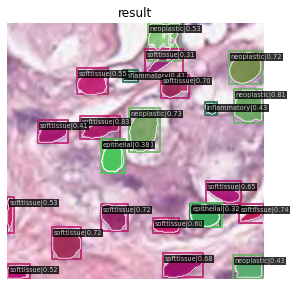

In [12]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv

img = mmcv.imread('../../input/pannuke-coco/val/image_100.jpg')

model.cfg = cfg_inference
result = inference_detector(model, img)
show_result_pyplot(model, img, result)